## Summary 

There are binary classification problem. Output format should be (submission.csv):  
id,result  
5844437,1  
5844438,1  
5844440,1  
5844443,1  
5844444,1  
5844445,1  
...
---
We need to find for all(854) students their knowleges and 


In [352]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

print("setup completed")

setup completed


In [353]:
data = pd.read_csv("train.csv", index_col='id')
data_test = pd.read_csv("test.csv", index_col='id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290895 entries, 2173111 to 5843569
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      290895 non-null  int64 
 1   unit_id      290895 non-null  int64 
 2   result       290895 non-null  int64 
 3   modified_at  290895 non-null  object
 4   type         290895 non-null  object
 5   is_step      290895 non-null  bool  
 6   problem_id   290895 non-null  int64 
 7   created_at   290895 non-null  object
dtypes: bool(1), int64(4), object(3)
memory usage: 18.0+ MB


In [354]:
#change type is_step to int
data['is_step'] = data['is_step'].astype(int)
data_test['is_step'] = data_test['is_step'].astype(int)
#replase result 2 on 1
data['result'] = data['result'].replace(2, 1)
data.describe()

,user_id,unit_id,result,is_step,problem_id
count,290895.000000,290895.000000,290895.000000,290895.000000,2.908950e+05
mean,45492.520160,9630.853115,0.831451,0.144495,6.332009e+06
std,12287.390028,2699.671957,0.374354,0.351592,2.609964e+05
min,8477.000000,854.000000,0.000000,0.000000,5.777943e+06
25%,33139.000000,10437.000000,1.000000,0.000000,6.173430e+06
50%,46228.000000,10621.000000,1.000000,0.000000,6.320678e+06
75%,57924.000000,10956.000000,1.000000,0.000000,6.388615e+06
max,65691.000000,12741.000000,1.000000,1.000000,6.857768e+06


In [355]:
data_test.describe()

,user_id,unit_id,result,is_step,problem_id
count,26270.000000,26270.000000,0.0,26270.000000,2.627000e+04
mean,60057.314046,9971.997982,NaN,0.144576,6.334816e+06
std,5635.922853,2431.058786,NaN,0.351679,2.634440e+05
min,26724.000000,854.000000,NaN,0.000000,5.779997e+06
25%,58032.000000,10608.000000,NaN,0.000000,6.187463e+06
50%,61427.000000,10937.000000,NaN,0.000000,6.279074e+06
75%,64065.000000,11073.000000,NaN,0.000000,6.395228e+06
max,65691.000000,12433.000000,NaN,1.000000,6.857762e+06


In [356]:
data_test.head()

,user_id,unit_id,result,modified_at,type,is_step,problem_id,created_at
id,,,,,,,,
5844437,64419,10485,NaN,2019-09-03T15:05:48.000Z,CHAPTERREVIEW,0,6779408,2019-09-03T15:05:15.000Z
5844438,64419,10377,NaN,2019-09-03T15:06:20.000Z,CHAPTERREVIEW,0,6775670,2019-09-03T15:05:56.000Z
5844440,64419,10488,NaN,2019-09-03T15:06:51.000Z,CHAPTERREVIEW,0,6779424,2019-09-03T15:06:28.000Z
5844443,64419,10429,NaN,2019-09-03T15:08:50.000Z,LESSON,0,6780710,2019-09-03T15:08:27.000Z
5844444,64419,10430,NaN,2019-09-03T15:09:50.000Z,LESSON,0,6780735,2019-09-03T15:08:59.000Z


In [357]:
print("types in data", data["type"].unique())
data.agg(['count', 'size', 'nunique'])

types in data ['LESSON' 'CHAPTERREVIEW' 'PLACEMENTTEST']


,user_id,unit_id,result,modified_at,type,is_step,problem_id,created_at
count,290895,290895,290895,290895,290895,290895,290895,290895
size,290895,290895,290895,290895,290895,290895,290895,290895
nunique,854,690,2,250526,3,2,25208,285369


In [358]:
print("On average students answering incorrectly for step questions")
data[["is_step", "result"]].groupby(['is_step'], as_index=False).mean().sort_values(by='result', ascending=False)

On average students answering incorrectly for step questions


,is_step,result
0,0,0.854506
1,1,0.694954


In [359]:
# this info we will use for testing our model(we should had the same statistic)!!!!!!!!!!!!!!!!
print("average resutls for all types")
data[["type", "result"]].groupby(['type'], as_index=False).mean().sort_values(by='result', ascending=False)

average resutls for all types


,type,result
0,CHAPTERREVIEW,0.875484
1,LESSON,0.827712
2,PLACEMENTTEST,0.610496


### Feature enginering

It is already clear that we need to create several new features  
based on the student's knowledge. Here are some ideas:

---
#### question_knowledge 
We will determine if the student has already taken the necessary  
lessons to solve this issue (based on unit-info.json);

---
#### intelligence
We will determine the total amount of student knowledge.  
This can be a bad feature for new students. Therefore,  
we will have to establish some kind of average level of   
training, average value for example. It is also necessary to normalize  
this feature, the student can understand one unit well and the other poorly.  

---
#### question_complexity  
How do students answer this question, on average.  
Standard value (for new questions): Average value for all questions.  

---
#### Important Notes:
- For all new features, we need to carefully choose the default values. And the variance in these values should be small. Because we will only make it worse.
- I have not figured out what to do with the dates, perhaps there is some kind of dependence in their difference, but we will remove that.
- For each feature, we have to check the correlation with the result. In any case, we will try to train the model with all the features and only the important ones.

## question_complexity

The average for the difficulty of the question is 0.763213.  
1 is a simple question (everyone answered correctly).  
0 is a hard question (all answered wrong).  

mean           0.763213
size       25208.000000
nunique      947.000000
Name: question_complexity, dtype: float64


C:\Users\pavlo\Anaconda3\envs\DataScience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='question_complexity', ylabel='Density'>

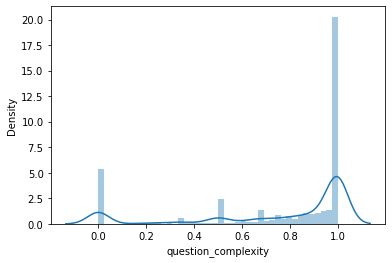

In [360]:
question_complexity = (
    data.groupby("problem_id") 
    ["result"].sum() / data.groupby("problem_id") 
    ["result"].count()                 
)
question_complexity.name="question_complexity"
print(question_complexity.agg(['mean', 'size', 'nunique']))
sns.distplot(question_complexity)

### intelligence

There are smart students. average intelligence 0.823986.

mean         0.823986
size       854.000000
nunique    790.000000
Name: intelligence, dtype: float64


C:\Users\pavlo\Anaconda3\envs\DataScience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='intelligence', ylabel='Density'>

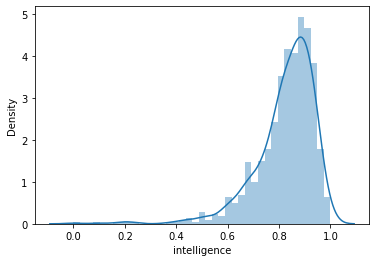

In [361]:
intelligence = (
    data.groupby("user_id") 
    ["result"].sum() / data.groupby("user_id") 
    ["result"].count()                 
)
intelligence.name="intelligence"
print(intelligence.agg(['mean', 'size', 'nunique']))
sns.distplot(intelligence)

## Model training

In [362]:
def add_featues(data_frame):
    result = pd.merge(data_frame, question_complexity, on='problem_id', how='outer')
    result = result.fillna(0.763213)
    result = pd.merge(result, intelligence, on='user_id', how='outer')
    result = result.fillna(0.823986)
    return result

In [363]:
data = add_featues(data)
data_test = add_featues(data_test)
data_test.describe()

C:\Users\pavlo\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,user_id,unit_id,result,is_step,problem_id,question_complexity,intelligence
count,45200.000000,45200.000000,45200.000000,45200.000000,4.520000e+04,45200.000000,45200.000000
mean,35654.650397,5795.992929,0.764225,0.404677,6.227311e+06,0.794490,0.826759
std,29662.487579,5257.020733,0.007778,0.407217,8.478162e+05,0.277634,0.066191
min,0.763213,0.763213,0.763213,0.000000,8.239860e-01,0.000000,0.000000
25%,0.763213,0.763213,0.763213,0.000000,6.183749e+06,0.729730,0.823301
50%,55696.000000,9332.000000,0.763213,0.763213,6.279156e+06,0.900000,0.823986
75%,62551.000000,10974.000000,0.763213,0.763213,6.388518e+06,1.000000,0.857369
max,65691.000000,12433.000000,0.823986,1.000000,6.857768e+06,1.000000,1.000000


In [364]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[['is_step', 'question_complexity', 'intelligence']], data['result'], test_size=0.33, random_state=1)

In [365]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

94.88

In [366]:
Y_final = random_forest.predict(data_test[['is_step', 'question_complexity', 'intelligence']])
print(Y_final.sum()/len(Y_final))
output = pd.DataFrame({'id': data_test.index, 'result': Y_final})
output.to_csv('my_submission.csv', index=False)

0.8345575221238938


In [367]:
# Let's compare the test and training sets for the number of the same students and questions. 
# If there are many different students and questions, the model will not work.
# Result: No new students and few new questions (good).
user_U_t = data['user_id'].unique()
user_U = data_test['user_id'].unique()
problem_U_t = data['problem_id'].unique()
problem_U = data_test['problem_id'].unique()

user_t = [1 for x in user_U if x not in user_U_t]
problem_t = [1 for x in problem_U if x not in problem_U_t]

print("different users ", len(user_t))
print("different problems", len(problem_t))

different users  1
different problems 850





* It is a mission to predict whether a student will get the right answer or not when he or she encounters a new question through learning data from students studying mathematics. Provide data for training and metadata surrounding it, and freely utilize the tools and methodologies you have to present a right or wrong prediction model.




### `curriculum-info.json`

*Metadata corresponding to Curriculum (grade) in mathematics curriculum with Curriculum-Chapter-Lesson-Unit. One Curriculum has multiple chapters.

* field information 
  * `id`: curriculum ID(Number)
  * `name`: name of curriculum(String)


### `chapter-info.json`

* Metadata corresponding to Chapter in a mathematics curriculum consisting of Curriculum-Chapter-Lesson-Unit. One Chapter has multiple Lessons.

* field information
  * `id`: chapter ID(Number)
  * `curriculum_id`: chapter inside curriculmn ID(Number)
  * `seq`: The order in which these chapters appear in your curriculum
  * `name`: chapter name(String)


### `lesson-info.json`

* Metadata corresponding to Lesson in a mathematics curriculum consisting of Curriculum-Chapter-Lesson-Unit. Lesson has multiple units, and one unit can belong to multiple Lessons.

* field information 
  * `id`: lesson ID(Number)
  * `chapter_id`: lesson inside chapter ID(Number)
  * `seq`: The order in which the lesson appears in your chapter.(Number)
  * `name`: lesson name(String)


### `unit-info.json`

* Metadata corresponding to Unit knowledge in mathematics curricula consisting of Curriculum-Chapter-Lesson-Unit.

* field information
  * `id`: unit of knowledge ID(Number)
  * `name`: unit of knowledge name(String)
  * `lessons`: List of lessons to which unit knowledge belongs(Array)
    * `id`: The lesson ID to which the unit knowledge belongs(Number)
    * `tier`: True if unit knowledge appears as a body problem in the lesson, false if only as a step problem


### `unit-dependency.json`

* Unit is the unit knowledge of a math problem. Some knowledge has prior knowledge to study that knowledge (for example, knowledge of factorization and quadratic equations is required to solve quadratic equations), which is data on this dependency graph.

* field information 
  * `id`: unit knowledge ID(Number)
  * `dependencies`: Arrangement of pre-knowledge IDs to study the unit knowledge(Array)


### `train.csv`

* This is the study data of students that will be used as a training set. It contains questions solved by students and data for right or wrong answers.

* Column Description
* 'id': Record Sequence (int)
* 'user_id': Student ID(int)
* 'unit_id': unit knowledge ID(int)
* 'result': Correct or wrong answer (0/1)
* 'modified_at': Record final modification timestamp (when correcting results after problem, this is the time stamp at the time of change)
* 'type': Record type
* 'LESSON': Records generated during lesson learning
* 'REVIEW': Records generated from lesson reviews after lesson learning
* 'CHAPTERREVIEW': Records generated from Chapter review after chapter learning
* 'PLACEMENTEST': Records generated from diagnostic evaluations
* 'is_step': whether it is a step problem (bool)
* `problem_id`: 문항 ID(int)  //////////////// question id
* Each unit knowledge is created into multiple questions using different values (for example, different coefficients in the "secondary factorization" unit knowledge).
* 'created_at': the first time stamp of a record (the time stamp when the problem log is generated prior to the problem)






## requirement

* Create a model that generates the 'submission.csv' file with the following two columns:
* 'id': Column value of test data (can be changed in order)
* 'result': Column value of test set record with corresponding 'id' predicted through model

You may also refer to the example result file 'submission-example.csv'.

* Please briefly specify how to run the model through the README file.

* Please briefly explain how you constructed your model through the README file, what assumptions you made, and why you made them.

* Some of the data in the training set may not meet the specifications specified above. The data preprocessing process is also intentionally placed so that it can be as close to the Real World dataset as possible, so you can process it in the appropriate way.
